In [1]:
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations, permutations, product

from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec
import ruptures as rpt
from ruptures.metrics import hausdorff, randindex, precision_recall

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_json('data/dev/cluster_2_cat.json')

In [3]:
df.head()

,id,date,title,body,subjects,category
0,3-6475540,2013-01-31T22:53:33+0200,UMK-finalistit valittu – Great Wide North maks...,Great Wide North sai toisessa semifinaalissa ...,"[kulttuuri, musiikki, viihde, uuden musiikin k...",musiikki
1,3-6474985,2013-01-31T15:32:31+0200,Vaganovan balettiakatemian kesäkurssi tulossa,Mikkeliläisen balettitapahtuman Savcor Ballet...,"[kulttuuri, baletti, savcor group, teatteritai...",musiikki
2,3-6474210,2013-01-31T13:57:18+0200,Liikuttaa ja koskettaa,Musiikki ei juurikaan sulostuta laitoksessa e...,"[terveys, kotimaan uutiset, kulttuuri, musiikk...",musiikki
3,3-6474612,2013-01-31T13:38:49+0200,Säveltäjä Krzysztof Penderecki loistaa musiikk...,Naantalin Musiikkijuhlat kunnioittaa ensi kes...,"[kulttuuri, krzysztof penderecki, naantali, mu...",musiikki
4,3-6474306,2013-01-31T13:30:58+0200,"Entisajan lepakko, nykyajan Batman",Lahdessa nähdään ja kuullaan opiskelijavoimin...,"[kulttuuri, batman, operetit, dc comics, lahti...",musiikki


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40994 entries, 0 to 40993
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        40994 non-null  object
 1   date      40994 non-null  object
 2   title     40994 non-null  object
 3   body      40994 non-null  object
 4   subjects  40994 non-null  object
 5   category  40994 non-null  object
dtypes: object(6)
memory usage: 2.2+ MB


In [5]:
df['body'] = df['title'] + '. ' + df['body']

In [6]:
# create artificial pivot points
# for each

def create_dataset(df, max_pivot=5, timeline=20, n_samples=100, min_docs=10, max_docs=100):
    df1 = df[df['category'] == 'luonto']
    df2 = df[df['category'] == 'musiikki']
    
    samples = []   # list article ids
    sample_pivots = []  # list of pivots index in timeline, need to map with ids
    
    for i in range(n_samples):
        # take random n articles from group 1 and 2
        # assign articles in group to rand(1, max_pivot)
        # pivot index is from 1 to max timeline, for example, timeline=10, pivots=[2, 6, 9]
        n_pivot = random.randint(low=1, high=(max_pivot+1))
        pivots = random.choice(range(1, timeline), size=n_pivot, replace=False)
        pivots = np.sort(pivots)
        
        # print(n_pivot, pivots)
        
        sample_pivots.append(pivots)
        # [0, 1], [1, 2]
        pivot_switch = False
        sample = []
        timeline_range = np.concatenate((np.array([0], dtype=int), pivots))
        
        for j, p in enumerate(timeline_range):
            n_doc = random.choice(range(min_docs, max_docs))
            # set init low as 0 and final high = timeline + 1 (ex bound of randint)
            high = timeline if j == len(timeline_range) - 1 else timeline_range[j+1]
            low = p
            
            if pivot_switch:
                group = df2[['id', 'category']].sample(n=n_doc)
            else:
                group = df1[['id', 'category']].sample(n=n_doc)
            
            # print("group", len(group))
            
            # map random id in group to the time unit
            # print(f'low {low} - high {high}')
            
            group['time'] = random.choice(range(low, high), size=n_doc)
            # assign next prepoint is current pivot point
            pivot_switch = pivot_switch == False
            
            sample.append(group)

        sample = pd.concat(sample, ignore_index=False)
        sample.sort_values('time', inplace=True)
        # sample.reset_index(drop=True, inplace=True)
        samples.append(sample)
        
    return samples, sample_pivots

In [7]:
%%time
n_samples = 100
dataset = create_dataset(df, max_pivot=3, timeline=100, n_samples=n_samples, min_docs=500, max_docs=1000)

CPU times: user 806 ms, sys: 0 ns, total: 806 ms
Wall time: 808 ms


In [8]:
samples, pivots = dataset

In [190]:
# with open('data/dev/cluster_1_pivot.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

In [191]:
# with open('data/dev/cluster_dataset_2.pkl', 'rb') as f:
#      dataset = pickle.load(f)

In [12]:
rand_id = np.random.randint(n_samples)
df_sample = samples[rand_id].copy()
pivot_sample = pivots[rand_id]

In [13]:
pivot_sample

array([ 4,  8, 27])

In [37]:
df_sample.tail()

,id,category,body,time
1750,3-6710352,musiikki,"Kirjanystävät Sastamalaan, kuvataiteista pitäv...",99
19648,3-5335834,musiikki,Karaoke villitsee Pieksämäen eläkeläisiä. Elä...,99
11595,3-7929316,musiikki,Kuinka saisin rikki kookospähkinän?. Kemiläis...,99
20225,3-5465506,musiikki,Joroisten Musiikkipäiville savonlinnalainen su...,99
13380,20-257007,musiikki,Biisibattle: Radioactive. Maailma on pullolla...,99


In [14]:
# vectorizer = TfidfVectorizer()
# corpus = df_sample['body']

# X = vectorizer.fit_transform(corpus)

In [31]:
# sim_mat = cosine_similarity(X)

In [32]:
# sim_mat.shape

(2194, 2194)

In [9]:
# try doc2vec model
doc2vec = Doc2Vec.load('models/doc2vec_full')

In [10]:
# infering to sample docs
def infer_doc2vec(docs, model):
    # tokenize the docs
    tokenized = docs.apply(simple_preprocess)
    vecs = np.zeros((len(docs), model.vector_size))
    
    for i, tokens in enumerate(tokenized):
        vecs[i] = doc2vec.infer_vector(tokens)
    
    return vecs

In [11]:
%%time
doc_vecs = infer_doc2vec(df['body'], doc2vec)

CPU times: user 10min, sys: 503 ms, total: 10min 1s
Wall time: 10min 3s


In [10]:
doc_vecs.shape

(40994, 128)

In [14]:
sample_vecs = doc_vecs[list(df_sample.index)]
df_sample.reset_index(inplace=True, drop=True)

In [15]:
sim_mat = cosine_similarity(sample_vecs)

In [16]:
sim_mat.shape

(3295, 3295)

In [15]:
def calculate_similarity_window(df, sim_mat, timeline, window=2, offset=1):
    steps = timeline - window + 1
    
    mean_sim = np.zeros(steps)
    total = 0
    
    for i in range(steps):
        # get all articles having time < window
        df_sub = df[(df['time'] < window + i) & (df['time'] >= i)]
        # print(df_sub.index[:10])
        pairwise_index = list(combinations(list(df_sub.index), 2))
        pairwise_index = tuple(zip(*pairwise_index))
        # print(pairwise_index)
        
        sim_scores = sim_mat[pairwise_index]
        # print(sim_scores)
        mean_sim[i] = np.mean(sim_scores)
        
        # print(df_sub.shape)
        total += df_sub.shape[0]

    print(total)
    
    return mean_sim

def get_sim_window(df, sim_mat, timeline, window=2, n_shuff=10):
    # idea, calculate for tfidf for group1, group2, and mix
    # calculate the diff: (g1 - mix)^2 + (g2 -mix)^2
    total = 0
    mean_sim = np.zeros(timeline - 1)
    
    for i in range(timeline - 1):
        # get all article for i and i + 1
        df_sub1 = df[df['time'] == i]
        df_sub2 = df[df['time'] == i+1]
        
        pairwise_index = list(product(list(df_sub1.index), list(df_sub2.index)))
        pairwise_index = tuple(zip(*pairwise_index))
        sim_scores = sim_mat[pairwise_index]
        
        avg_sim_mix = 0
        df_sub = pd.concat([df_sub1, df_sub2])
        
        for n in range(n_shuff):
            # now do the same, but mix up the index of 2 group
            df_mix1, df_mix2 = train_test_split(df_sub, test_size=0.5)

            pairwise_index = list(product(list(df_mix1.index), list(df_mix2.index)))
            pairwise_index = tuple(zip(*pairwise_index))
            sim_scores_mix = sim_mat[pairwise_index]
            
            avg_sim_mix += np.mean(sim_scores_mix)
        
        avg_sim_mix = avg_sim_mix / n_shuff
        avg_sim_scores = np.mean(sim_scores)
        
        mean_sim[i] = (avg_sim_mix - avg_sim_scores) / avg_sim_scores
        
    return mean_sim
        

def get_sim_window_2(df, sim_mat, timeline, window=2):
    # idea, calculate for tfidf for group1, group2, and mix
    # calculate the diff: (g1 - mix)^2 + (g2 -mix)^2
    total = 0
    mean_sim = np.zeros(timeline - 1)
    
    for i in range(timeline - 1):
        # get all article for i and i + 1
        df_sub1 = df[df['time'] == i]
        df_sub2 = df[df['time'] == i+1]
        
        pairwise_index = list(combinations(list(df_sub1.index), 2))
        # print("origin", pairwise_index[:10])
        pairwise_index = tuple(zip(*pairwise_index))
        sim_scores_1 = sim_mat[pairwise_index]
        
        pairwise_index = list(combinations(list(df_sub2.index), 2))
        pairwise_index = tuple(zip(*pairwise_index))
        sim_scores_2 = sim_mat[pairwise_index]
        
        
        # now do the same, but mix up the index of 2 group
        df_sub = pd.concat([df_sub1, df_sub2])
        df_mix1, df_mix2 = train_test_split(df_sub, test_size=len(df_sub2))
        # print(len(df_mix1), len(df_sub1))
        
        pairwise_index = list(combinations(list(df_mix1.index), 2))
        pairwise_index = tuple(zip(*pairwise_index))
        sim_scores_mix_1 = sim_mat[pairwise_index]
        
        pairwise_index = list(combinations(list(df_mix2.index), 2))
        pairwise_index = tuple(zip(*pairwise_index))
        sim_scores_mix_2 = sim_mat[pairwise_index]
        
        # pairwise_index = list(product(list(df_mix1.index), list(df_mix2.index)))
        # print("mixed", pairwise_index[:10])
        # pairwise_index = tuple(zip(*pairwise_index))
        # sim_scores_2 = sim_mat[pairwise_index]
        
        diff_scores_1 = (np.mean(sim_scores_1) - np.mean(sim_scores_mix_1)) / np.mean(sim_scores_1)
        diff_scores_2 = (np.mean(sim_scores_2) - np.mean(sim_scores_mix_2)) / np.mean(sim_scores_2)
        

        # print(sim_scores)
        mean_sim[i] = diff_scores_1 + diff_scores_2
        
        # print(df_sub.shape)
        # total += df_sub.shape[0]
        
    # print(total)
    
    return mean_sim
    

In [30]:
sim_steps = get_sim_window(df_sample, sim_mat, timeline=100, window=2, n_shuff=10)

In [19]:
sim_steps.shape

(99,)

[-6.46009091e+00 -5.29825602e+00 -4.29859735e+00 -3.68527781e+00
 -3.27198712e+00 -3.24981058e+00 -3.18794857e+00 -3.18744686e+00
 -2.91143207e+00 -2.71038436e+00 -2.64196135e+00 -2.49549488e+00
 -2.49476937e+00 -2.44230213e+00 -2.23717409e+00 -2.13122764e+00
 -2.09128333e+00 -1.91500590e+00 -1.90002454e+00 -1.75607550e+00
 -1.66699827e+00 -1.61141555e+00 -1.53770520e+00 -1.43817625e+00
 -1.42978184e+00 -1.36008866e+00 -1.31671876e+00 -1.25879887e+00
 -1.25012849e+00 -1.20194456e+00 -1.11495902e+00 -1.04228962e+00
 -9.07489815e-01 -8.70351163e-01 -8.31950836e-01 -7.84380111e-01
 -7.49902735e-01 -7.05748951e-01 -6.91532955e-01 -5.47169058e-01
 -5.27385296e-01 -4.89297800e-01 -4.68476588e-01 -4.66897867e-01
 -4.38183810e-01 -4.04174331e-01 -3.99990738e-01 -3.75535350e-01
 -3.67968667e-01 -3.18961537e-01 -2.56966893e-01 -1.64891173e-01
 -1.34383599e-01 -4.80976857e-02 -3.51271170e-02 -1.44980746e-02
  1.03901425e-02  3.33032100e-02  9.54759996e-02  1.01699672e-01
  1.55315461e-01  1.89139

<Figure size 1440x720 with 0 Axes>

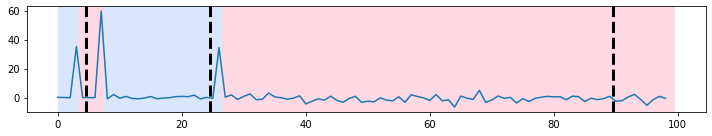

In [31]:
# generate signal
# n_samples, dim, sigma = 1000, 1, 1

# signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)
signal = sim_steps * 100
bkps = np.concatenate((pivot_sample, np.array([100])))
print(np.sort(signal))
print(bkps)
# detection
algo = rpt.Window(model="normal", width=5).fit(signal)
result = algo.predict(len(bkps) - 1)
# display

plt.figure(figsize=(20,10))
rpt.display(signal, bkps, result)

plt.show()


In [12]:
def detect_change_points(data, up_rate=2):
    mu = np.mean(data)
    std = np.std(data)
    cut_off = std * up_rate
    upper = mu + cut_off
    
    outliers = [(i+1, x) for i, x in enumerate(data) if x > upper]
    
    return outliers

In [36]:
change_points = detect_change_points(sim_steps)

In [37]:
print(change_points)

[(4, 0.35164763918236847), (8, 0.5965882808347635), (27, 0.3450647199255043)]


In [35]:
pivot_sample

array([ 4,  8, 27])

In [13]:
def get_pivots_batch(dataset, doc_vecs, timeline=100):
    samples, pivots = dataset
    
    pred_points = []
    
    for df in tqdm(samples):
        sample_vecs = doc_vecs[list(df.index)]
        df_reset = df.reset_index(drop=True)  # important so sim_mat will have same index as df
        
        sim_mat = cosine_similarity(sample_vecs)
        sim_steps = get_sim_window(df_reset, sim_mat, timeline=timeline, window=2, n_shuff=10)
        
        change_points = detect_change_points(sim_steps, 3)
        pred_points.append(change_points)
        
    return pred_points, pivots

In [16]:
preds, labels = get_pivots_batch(dataset, doc_vecs)

100%|██████████| 100/100 [02:16<00:00,  1.37s/it]


In [130]:
preds[:2]

[[(46, 0.29770628245733544), (84, 0.24376014344495006)],
 [(30, 0.1547618906617202),
  (62, 0.3609478827830846),
  (81, 0.2741120871979705)]]

In [131]:
labels[:2]

[array([46, 84]), array([62, 81])]

In [17]:
def evaluate(preds, labels, timeline):
    metrics = []
    
    for pred_p, label in zip(preds, labels):
        points, scores = zip(*pred_p)
        points = np.array(points, dtype=int)
        # the library require the last point in timeline in the list
        pred_points = np.concatenate((points, [timeline]))
        true_points = np.concatenate((label, [timeline]))
        
        hdf = hausdorff(true_points, pred_points)
        rdx = randindex(true_points, pred_points)
        p, r = precision_recall(true_points, pred_points, margin=1)
        
        metrics.append((hdf, rdx, p, r))
        
    return metrics
        

In [18]:
%%time
metrics = evaluate(preds, labels, 100)

CPU times: user 47.4 ms, sys: 995 µs, total: 48.4 ms
Wall time: 56 ms


In [19]:
metrics = np.array(metrics)

In [20]:
avg_metrics = np.mean(metrics, axis=0)

In [21]:
avg_metrics

array([4.99      , 0.96757   , 0.95166667, 0.96666667])

In [ ]:
# 2.0 std: [13.66    , 0.922014,  0.825   ,  0.995   ]
# 2.5 std: [9.26     , 0.944602  , 0.8875    , 0.98666667]
# 3.0 std: [5.13     , 0.964308  , 0.95083333, 0.98333333]